# Identify a MHW

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import dask
import dask.array as dsa
from xgcm import Grid
#import regionate as reg

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

era23 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/gom_updated.zarr'))
era1022 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/surf_ds_2010_22.zarr'))

In [3]:
era_hrly = xr.concat([era1022, era23], dim='time')

In [4]:
era_hrly.sst

<xarray.DataArray 'sst' (time: 122712, latitude: 41, longitude: 113)> Size: 5GB
dask.array<concatenate, shape=(122712, 41, 113), dtype=float64, chunksize=(8760, 41, 113), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 452B -100.0 -99.75 -99.5 ... -72.25 -72.0
  * time       (time) datetime64[ns] 982kB 2010-01-01 ... 2023-12-31T23:00:00
Attributes:
    long_name:  Sea surface temperature
    units:      K

In [5]:
sst = era_hrly.sst - 273.15
sst

<xarray.DataArray 'sst' (time: 122712, latitude: 41, longitude: 113)> Size: 5GB
dask.array<sub, shape=(122712, 41, 113), dtype=float64, chunksize=(8760, 41, 113), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 452B -100.0 -99.75 -99.5 ... -72.25 -72.0
  * time       (time) datetime64[ns] 982kB 2010-01-01 ... 2023-12-31T23:00:00

# Compute 90th percentile
(contour plots differ based on how many prev yrs (prior to 2023) are included in calculation, bc prior years were cooler on avg. State of sst is rising every year)

In [32]:
q90 = sst.sel(time=slice('2018', '2023'), 
              latitude=slice(31, 21), 
              longitude=slice(-100, -80)).chunk({'time':-1}).quantile(0.90, dim='time')
q99 = sst.sel(time=slice('2018', '2023'), 
              latitude=slice(31, 21), 
              longitude=slice(-100, -80)).chunk({'time':-1}).quantile(0.99, dim='time')
q95 = sst.sel(time=slice('2018', '2023'), 
              latitude=slice(31, 21), 
              longitude=slice(-100, -80)).chunk({'time':-1}).quantile(0.95, dim='time')

In [33]:
q90

<xarray.DataArray 'sst' (latitude: 41, longitude: 81)> Size: 27kB
dask.array<getitem, shape=(41, 81), dtype=float64, chunksize=(41, 81), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
    quantile   float64 8B 0.9

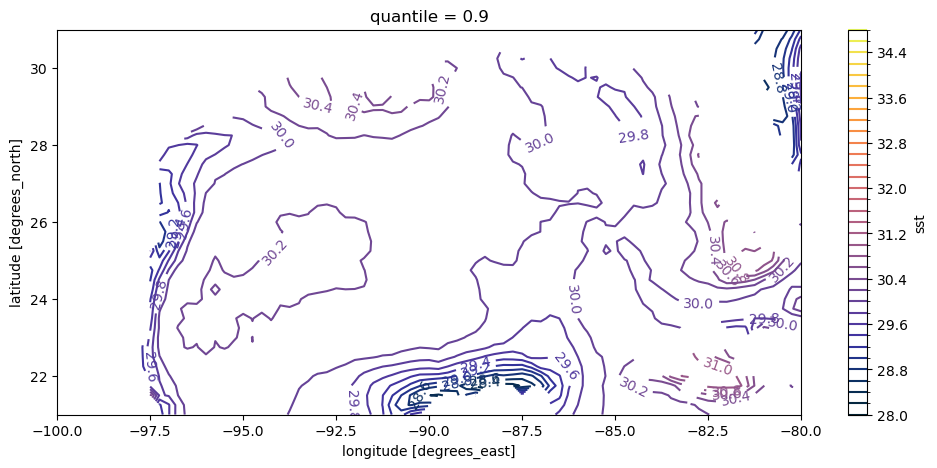

In [35]:
theta_levs = np.arange(28,35,0.2)

fig, ax = plt.subplots(figsize=(12,5))
C = q90.plot.contour(colors=cmocean.cm.thermal, levels=theta_levs, ax=ax, add_colorbar=True)
plt.clabel(C);

<a list of 0 text.Text objects>

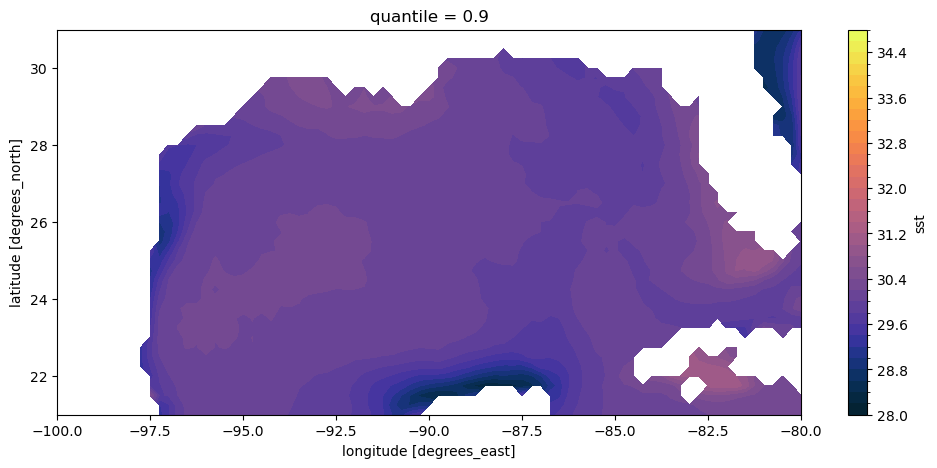

In [34]:
plt.figure(figsize=(12,5))
q90.plot.contourf(levels=np.arange(28, 35, 0.2), colors=cmocean.cm.thermal, add_colorbar=True)

c = q90.plot.contour(levels=[31.8], colors='k')
plt.clabel(c)

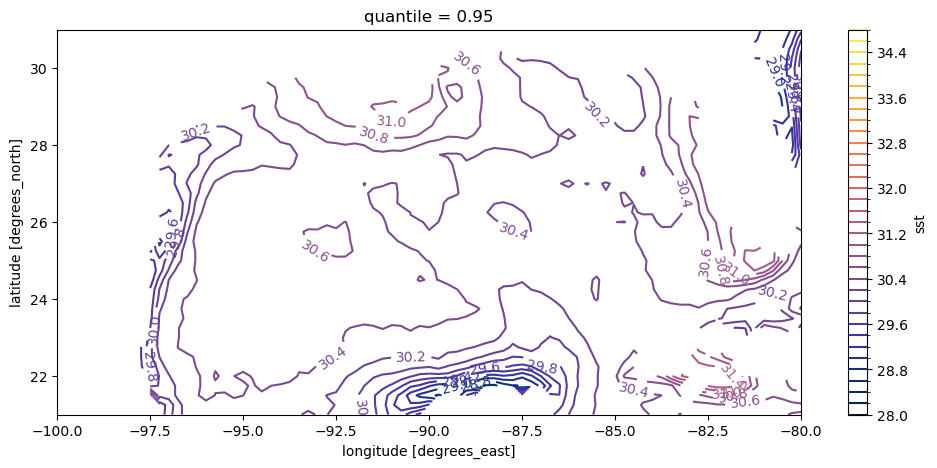

In [36]:
theta_levs = np.arange(28,35,0.2)

fig, ax = plt.subplots(figsize=(12,5))
C = q95.plot.contour(colors=cmocean.cm.thermal, levels=theta_levs, ax=ax, add_colorbar=True)
plt.clabel(C);

<a list of 0 text.Text objects>

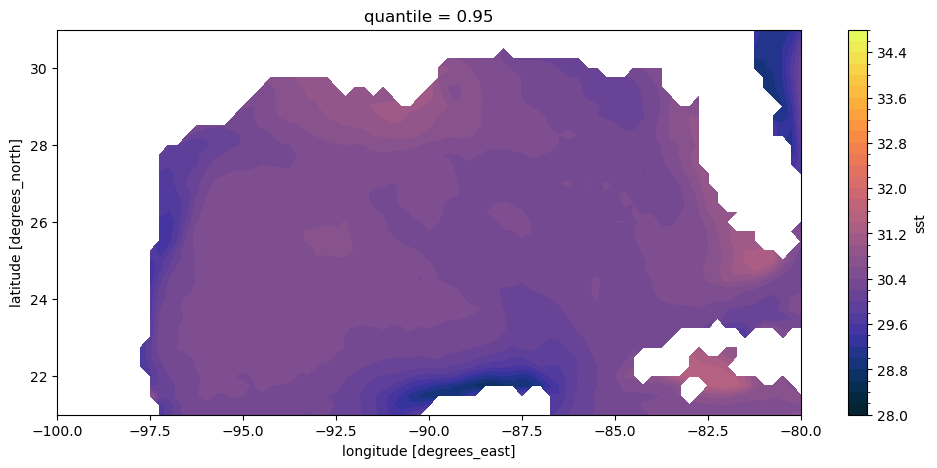

In [37]:
plt.figure(figsize=(12,5))
q95.plot.contourf(levels=np.arange(28, 35, 0.2), colors=cmocean.cm.thermal, add_colorbar=True)

c = q95.plot.contour(levels=[31.8], colors='k')
plt.clabel(c)

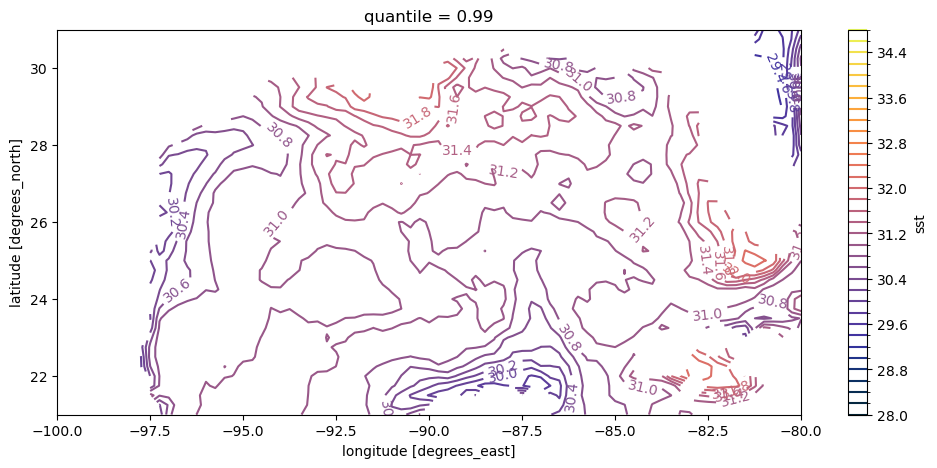

In [38]:
theta_levs = np.arange(28,35,0.2)

fig, ax = plt.subplots(figsize=(12,5))
C = q99.plot.contour(colors=cmocean.cm.thermal, levels=theta_levs, ax=ax, add_colorbar=True)
plt.clabel(C);

<a list of 3 text.Text objects>

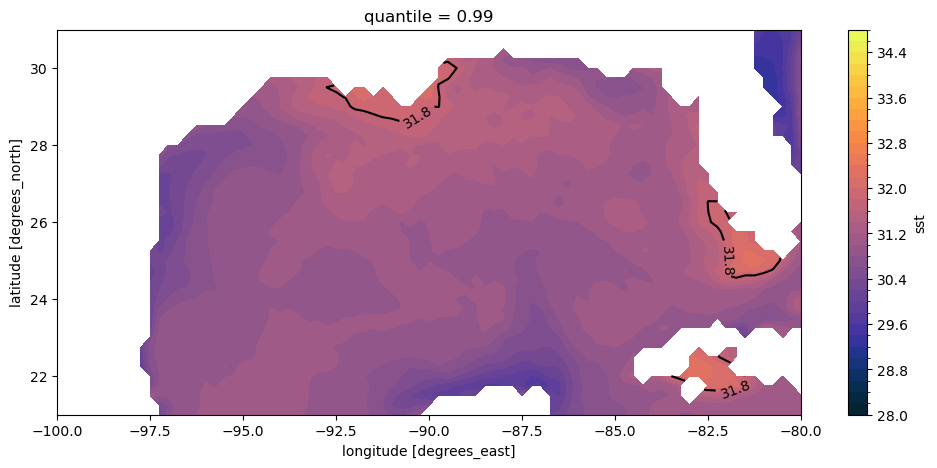

In [39]:
plt.figure(figsize=(12,5))
q99.plot.contourf(levels=np.arange(28, 35, 0.2), colors=cmocean.cm.thermal, add_colorbar=True)

c = q99.plot.contour(levels=[31.8], colors='k')
plt.clabel(c)

# Compute daily/monthly climatology and anomaly

In [40]:
#resample to daily to get rid of diurnal cycle
sst_resampled = sst.sel(time=slice('2015', '2023')).resample(time='D').mean()

In [41]:
#daily clim
#with dask.config.set(**{'array.slicing.split_large_chunks': True}):

clim = sst_resampled.groupby('time.dayofyear').mean('time')
#clim_std = sst_resampled.groupby('time.dayofyear').std('time')
anom = sst_resampled.groupby('time.dayofyear') - clim

#monthly clim
mo_clim = sst_resampled.groupby('time.month').mean('time')
#mo_clim_std = sst_resampled.groupby('time.month').std('time')
mo_anom = sst_resampled.groupby('time.month') - mo_clim

In [42]:
anom

<xarray.DataArray 'sst' (time: 3287, latitude: 41, longitude: 113)> Size: 122MB
dask.array<sub, shape=(3287, 41, 113), dtype=float64, chunksize=(159, 41, 113), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 452B -100.0 -99.75 -99.5 ... -72.25 -72.0
  * time       (time) datetime64[ns] 26kB 2015-01-01 2015-01-02 ... 2023-12-31
    dayofyear  (time) int64 26kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365

In [43]:
sst_fl = sst_resampled.sel(latitude=slice(31, 21), longitude=slice(-100, -80))
anom_fl = anom.sel(latitude=slice(31, 21), longitude=slice(-100, -80))
clim_fl = clim.sel(latitude=slice(31, 21), longitude=slice(-100, -80))

In [45]:
sst_fl

<xarray.DataArray 'sst' (time: 3287, latitude: 41, longitude: 81)> Size: 87MB
dask.array<getitem, shape=(3287, 41, 81), dtype=float64, chunksize=(365, 41, 81), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 26kB 2015-01-01 2015-01-02 ... 2023-12-31

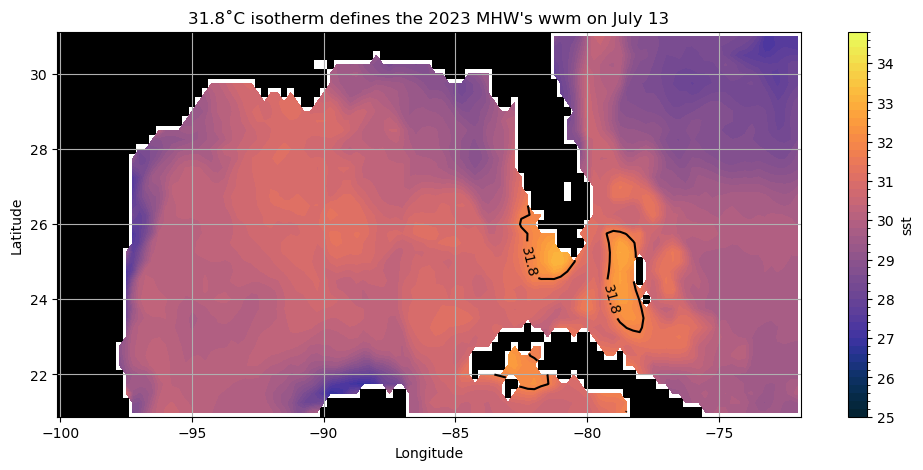

In [56]:
#provide a plot to compare against NOAA's 2023 summer map of the MHW blob

sst_fl_noaa = sst_resampled.sel(latitude=slice(31, 21))

plt.figure(figsize=(12,5))

cmap = plt.cm.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask = sst_fl_noaa[0].isnull()
mask.plot(cmap=cmap, add_colorbar=False)

sst_fl_noaa.sel(time='2023-07-13', method='nearest').plot.contourf(levels=np.arange(25, 35, 0.2), 
                                                              colors=cmocean.cm.thermal, add_colorbar=True)
c = sst_fl_noaa.sel(time='2023-07-13', method='nearest').plot.contour(levels=[31.8], colors='k')
plt.clabel(c)
plt.grid()
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title("31.8˚C isotherm defines the 2023 MHW's wwm on July 13");

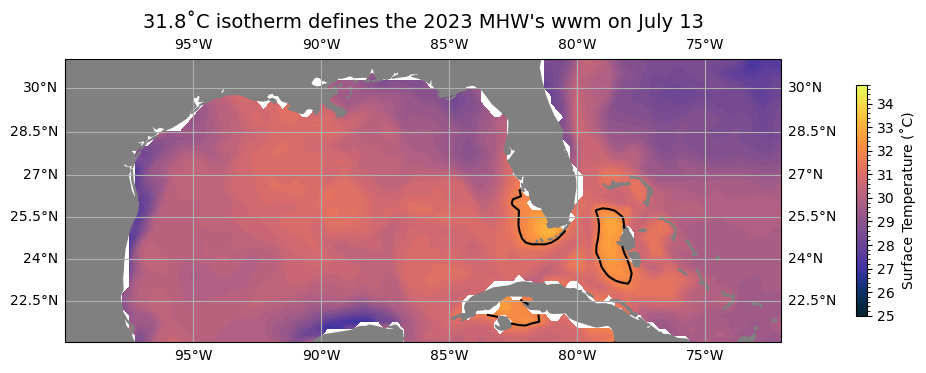

In [94]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(12, 15), subplot_kw=dict(projection=proj))

noaa = sst_fl_noaa.sel(time='2023-07-13', method='nearest')

ax.set_extent([-100, -72, 21, 31], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'), rasterized=True)
im = noaa.plot.contourf(ax=ax, levels=np.arange(25, 35, 0.2), colors=cmocean.cm.thermal,
                        transform=ccrs.PlateCarree(), add_colorbar=True, rasterized=True,
                        cbar_kwargs={'label':'Surface Temperature (˚C)', 'shrink':0.2, 'pad':0.08})

noaa.plot.contour(ax=ax, levels=[31.8], colors='k', transform=ccrs.PlateCarree(), rasterized=True)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title("31.8˚C isotherm defines the 2023 MHW's wwm on July 13", fontsize=14, y=1.08);
plt.savefig('paper-figs/era/isotherm-july13.pdf', transparent=True)

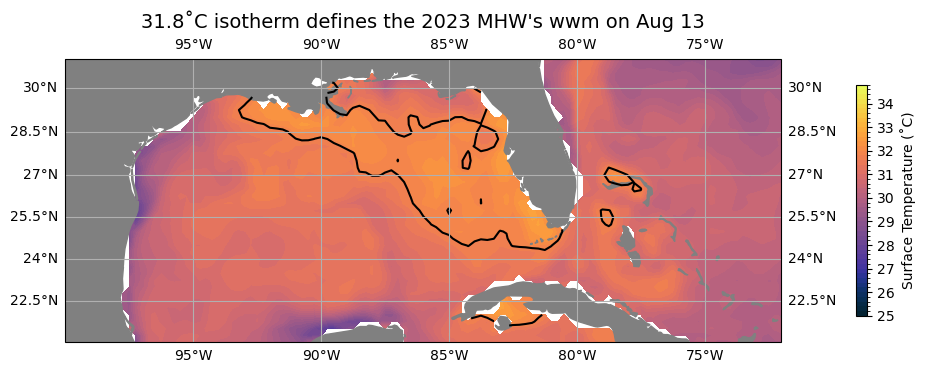

In [93]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(12, 15), subplot_kw=dict(projection=proj))

noaa = sst_fl_noaa.sel(time='2023-08-13', method='nearest')

ax.set_extent([-100, -72, 21, 31], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'), rasterized=True)
im = noaa.plot.contourf(ax=ax, levels=np.arange(25, 35, 0.2), colors=cmocean.cm.thermal,
                        transform=ccrs.PlateCarree(), add_colorbar=True, rasterized=True,
                        cbar_kwargs={'label':'Surface Temperature (˚C)', 'shrink':0.2, 'pad':0.08})

noaa.plot.contour(ax=ax, levels=[31.8], label='31.8', colors='k', transform=ccrs.PlateCarree(), rasterized=True)
#ax.clabel(c, inline=1)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title("31.8˚C isotherm defines the 2023 MHW's wwm on Aug 13", fontsize=14, y=1.08);
plt.savefig('paper-figs/era/isotherm-aug13.pdf', transparent=True)

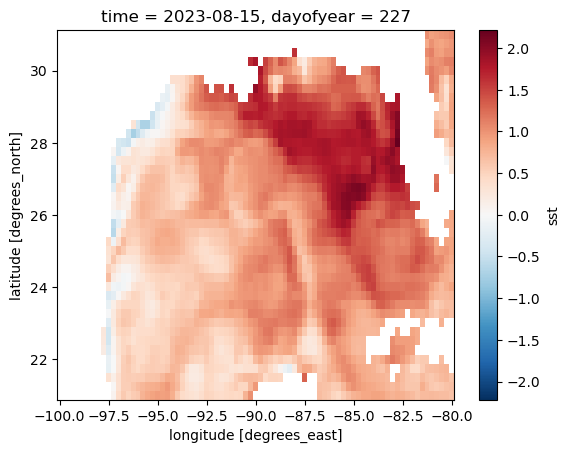

In [44]:
anom_fl[3148].plot()

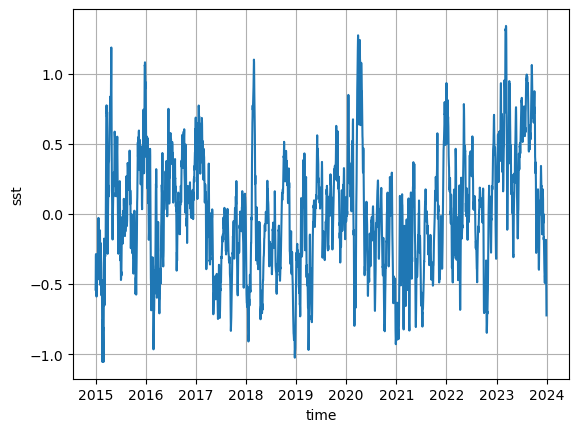

In [34]:
anom_fl.mean(['latitude', 'longitude']).plot()
plt.grid();

In [35]:
#only keep May-Oct months
may_oct = anom_fl.sel(time=anom_fl.time.dt.month.isin([5, 6, 7, 8, 9, 10]))

In [36]:
may_oct

<xarray.DataArray 'sst' (time: 1656, latitude: 41, longitude: 81)> Size: 44MB
dask.array<getitem, shape=(1656, 41, 81), dtype=float64, chunksize=(54, 41, 81), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 13kB 2015-05-01 2015-05-02 ... 2023-10-31
    dayofyear  (time) int64 13kB 121 122 123 124 125 126 ... 300 301 302 303 304

In [37]:
anom_may_oct = anom_fl.where(anom_fl.time==may_oct.time)

In [38]:
anom_may_oct.shape

(1656, 41, 81)

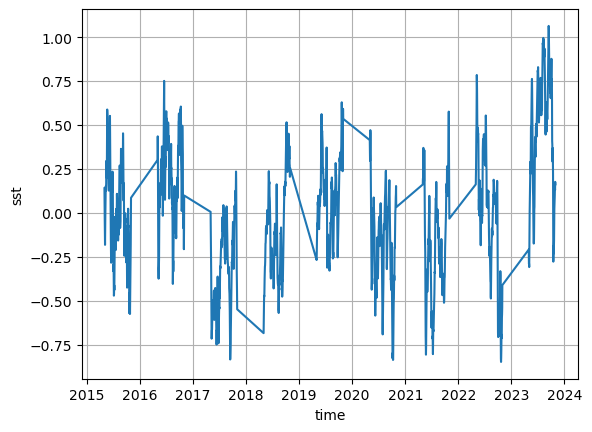

In [39]:
anom_may_oct.mean(['latitude', 'longitude']).plot()
plt.grid();

In [40]:
print('Date where max anom temp occurs:', 
      str(anom_may_oct.mean(['latitude', 'longitude']).idxmax(dim='time').dt.strftime("%Y-%m-%d").values))

Date where max anom temp occurs: 2023-09-15


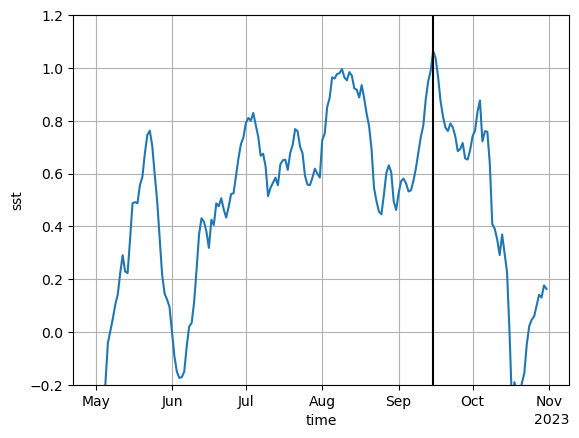

In [41]:
anom_may_oct.sel(time='2023').mean(['latitude', 'longitude']).plot()
plt.vlines(anom_may_oct.mean(['latitude', 'longitude']).idxmax(dim='time').values,
           ymin=-0.2, ymax=1.2, colors='k')
plt.ylim(-0.2, 1.2)
plt.grid();

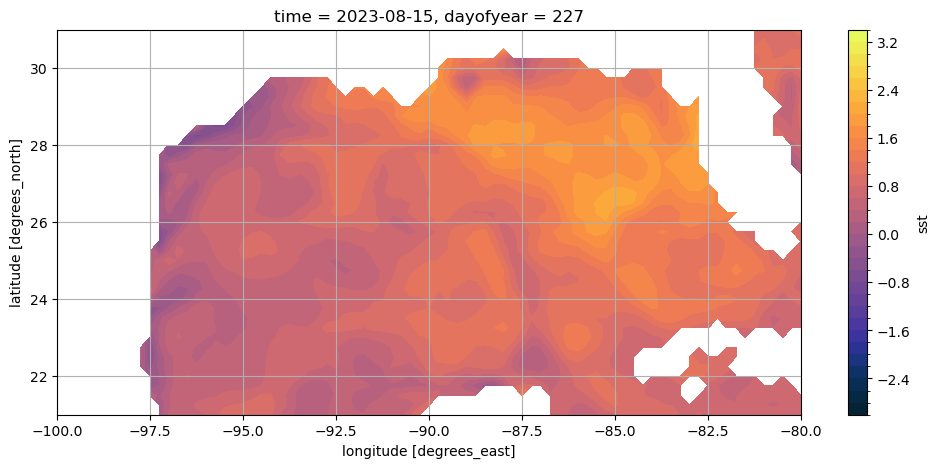

In [46]:
plt.figure(figsize=(12,5))
anom_fl.sel(time='2023-08-15', method='nearest').plot.contourf(levels=np.arange(-3, 3.5, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
plt.grid();

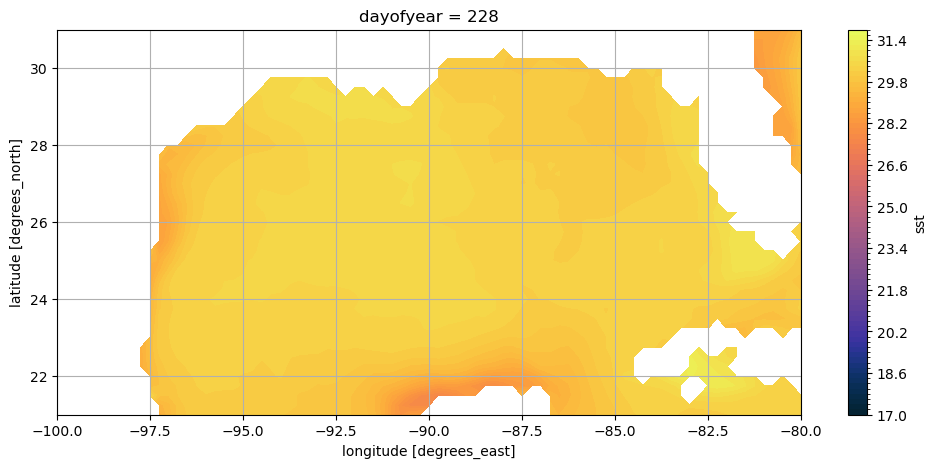

In [47]:
plt.figure(figsize=(12,5))
clim_fl.isel(dayofyear=227).plot.contourf(levels=np.arange(17, 32, 0.2), 
                                         colors=cmocean.cm.thermal, add_colorbar=True)
plt.grid();

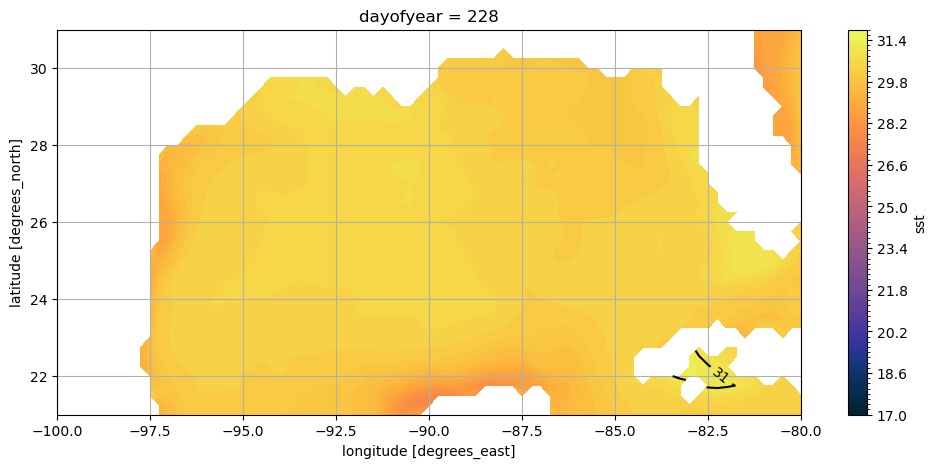

In [48]:
#aug 8
plt.figure(figsize=(12,5))
clim_fl.isel(dayofyear=227).plot.contourf(levels=np.arange(17, 32, 0.2), 
                                         colors=cmocean.cm.thermal, add_colorbar=True)
c = clim_fl.isel(dayofyear=227).plot.contour(levels=[31], colors='k')
plt.clabel(c)
plt.grid();

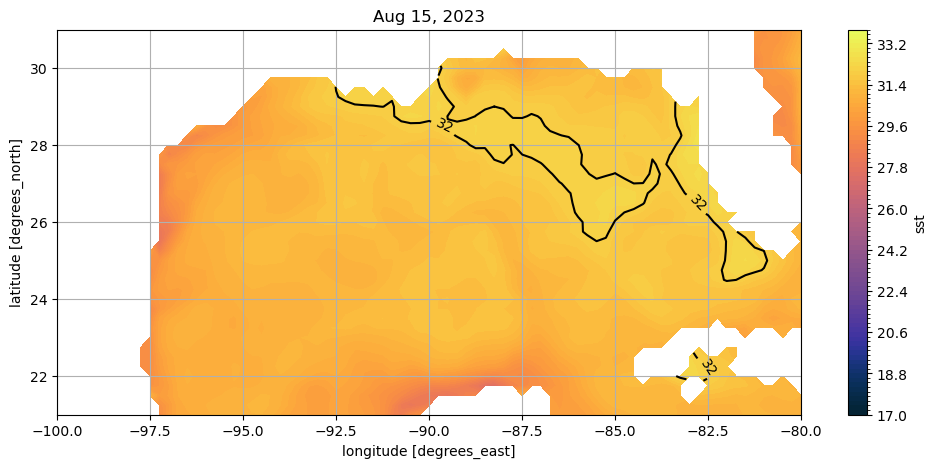

In [49]:
plt.figure(figsize=(12,5))
sst_fl.sel(time='2023-08-15', method='nearest').plot.contourf(levels=np.arange(17, 34, 0.2), 
                                         colors=cmocean.cm.thermal, add_colorbar=True)
c = sst_fl.sel(time='2023-08-15', method='nearest').plot.contour(levels=[32], colors='k')
plt.clabel(c)
plt.grid()
plt.title('Aug 15, 2023');

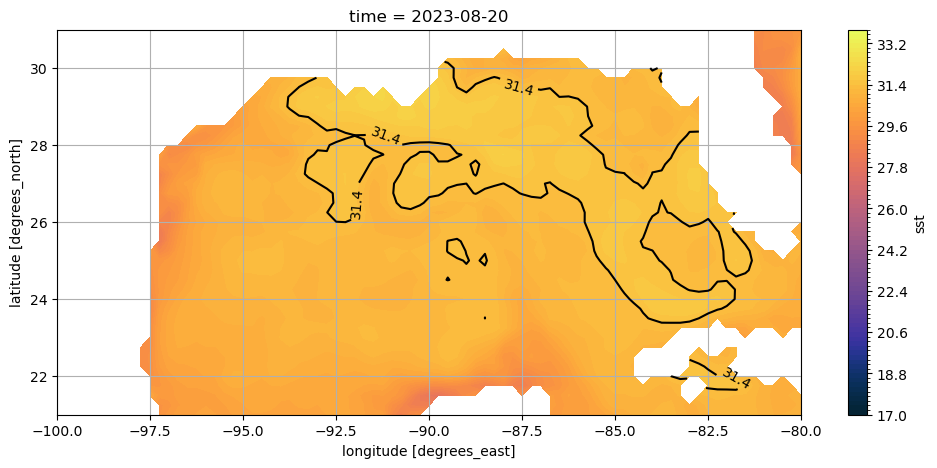

In [53]:
#plot absolute temp based on date associated with largest anomaly
plt.figure(figsize=(12,5))
sst_fl.sel(time='2023-08-20', method='nearest').plot.contourf(levels=np.arange(17, 34, 0.2), 
                                         colors=cmocean.cm.thermal, add_colorbar=True)
c = sst_fl.sel(time='2023-08-20', method='nearest').plot.contour(levels=[31.4], colors='k')
plt.clabel(c)
plt.grid()
#plt.title('August 8, 2023');

In [57]:
sst_fl.sel(time='2023').idxmax(dim='time')

<xarray.DataArray 'time' (latitude: 41, longitude: 81)> Size: 27kB
dask.array<where, shape=(41, 81), dtype=datetime64[ns], chunksize=(41, 81), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0

In [58]:
df = sst_fl.to_dataframe()

In [60]:
#find when else 32˚C contour occurs
for year in ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']:
    print(f'{year}:', df.loc[f'{year}']['sst'].round().value_counts()[32])

2015: 222
2016: 193
2017: 46
2018: 150
2019: 334
2020: 277
2021: 240
2022: 355
2023: 14469


In [61]:
df.loc['2018']['sst'].round().value_counts()[32]

150

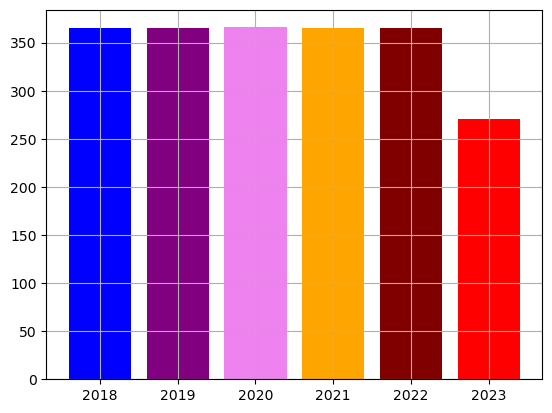

In [36]:
colors = ['blue', 'purple', 'violet', 'orange', 'maroon', 'red']
plt.bar(dt32.year, dt32, color=colors)
plt.grid()

In [16]:
idxmax_anom = anom_fl.sel(time=slice('2023-07-01', '2023-07-31')).idxmax(dim='time', skipna=True)
idxmax_clim = clim_fl.isel(dayofyear=slice(93, 125)).idxmax(dim='dayofyear', skipna=True)

In [20]:
argmax_anom = anom_fl.sel(time=slice('2023-07-01', '2023-07-31')).fillna(0.).argmax(dim='time')
argmax_clim = clim_fl.isel(dayofyear=slice(93,125)).fillna(0.).argmax(dim='dayofyear')

In [21]:
argmax_clim

<xarray.DataArray 'sst' (latitude: 37, longitude: 73)>
array([[31, 31, 31, ..., 31, 31, 31],
       [31, 31, 31, ..., 31, 31, 31],
       [31, 31, 31, ..., 31, 31, 31],
       ...,
       [ 0,  0,  0, ..., 31, 31, 31],
       [ 0,  0,  0, ..., 31, 31, 31],
       [ 0,  0,  0, ..., 31, 31, 31]])
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -90.0 -89.75 -89.5 ... -72.5 -72.25 -72.0

In [22]:
argmax_anom.values.max()

30

In [23]:
argmax_clim.max().values

array(31)

In [131]:
mask = anom_fl[0].isnull()

/tmp/ipykernel_440/1634276531.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Greys")


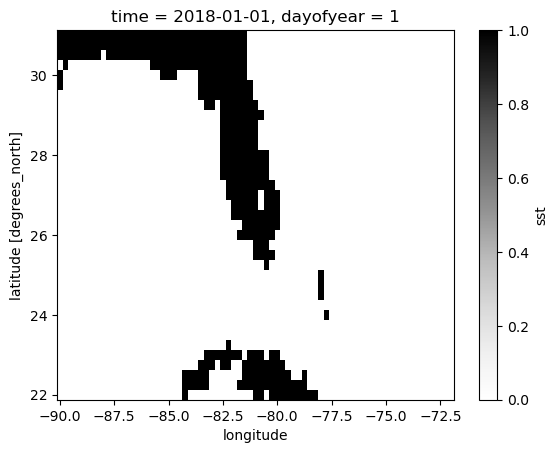

In [132]:
cmap = plt.cm.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask.plot(cmap=cmap)

/tmp/ipykernel_2007/3382194161.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Greys")


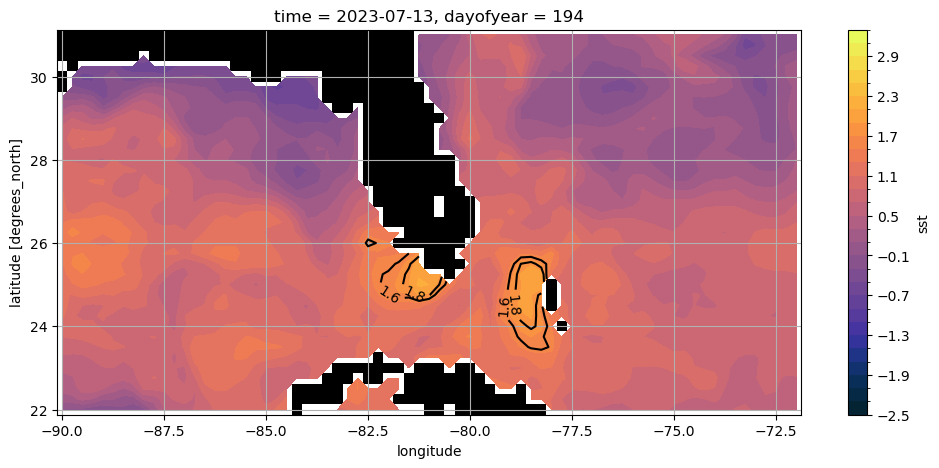

In [26]:
plt.figure(figsize=(12,5))

cmap = plt.cm.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask.plot(cmap=cmap, add_colorbar=False)

anom_fl.sel(time='2023-07-13', method='nearest').plot.contourf(levels=np.arange(-2.5, 3.5, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
c = anom_fl.sel(time='2023-07-13', method='nearest').plot.contour(levels=[1.6, 1.8], colors='k')
plt.clabel(c)
plt.grid();

/tmp/ipykernel_2007/2750899400.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Greys")


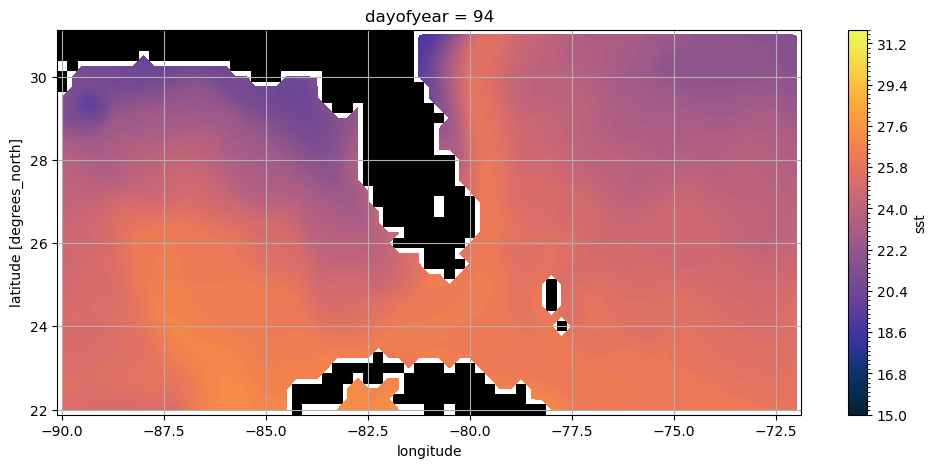

In [27]:
plt.figure(figsize=(12,5))

cmap = plt.cm.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask.plot(cmap=cmap, add_colorbar=False)

clim_fl.isel(dayofyear=93).plot.contourf(levels=np.arange(15, 32, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
plt.grid();

# Movie

In [89]:
#insert datetime object of same length as `dayofyear` coord in order for movie to run
x = np.arange('2222-01', '2223-01-02', dtype='datetime64[D]')

In [46]:
x.shape

(366,)

In [55]:
clim_ds = clim_fl.to_dataset()

In [56]:
clim_ds['time'] = x

In [59]:
clim_ds

<xarray.Dataset>
Dimensions:    (latitude: 37, longitude: 73, dayofyear: 366, time: 366)
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -90.0 -89.75 -89.5 ... -72.5 -72.25 -72.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
  * time       (time) datetime64[ns] 2222-01-01 2222-01-02 ... 2223-01-01
Data variables:
    sst        (dayofyear, latitude, longitude) float32 25.38 25.34 ... 21.91

In [124]:
sst_newcoords = clim_ds.assign_coords(time=x).drop('dayofyear').rename({'dayofyear':'time'})
sst = sst_newcoords.sst

In [125]:
sst

<xarray.DataArray 'sst' (time: 366, latitude: 37, longitude: 73)>
array([[[25.377245, 25.336836, 25.306631, ..., 26.717651, 26.658083,
         26.527847],
        [25.425833, 25.426651, 25.402071, ..., 26.752869, 26.7124  ,
         26.708   ],
        [25.437952, 25.454666, 25.463081, ..., 26.653334, 26.648867,
         26.659311],
        ...,
        [      nan,       nan,       nan, ..., 22.954851, 22.890112,
         22.799622],
        [      nan,       nan,       nan, ..., 22.833902, 22.81273 ,
         22.734621],
        [      nan,       nan,       nan, ..., 22.711647, 22.71855 ,
         22.692808]],

       [[25.34052 , 25.296652, 25.248001, ..., 26.652529, 26.615175,
         26.49034 ],
        [25.387568, 25.384493, 25.35222 , ..., 26.695755, 26.681534,
         26.67642 ],
        [25.404322, 25.421844, 25.419226, ..., 26.635263, 26.626997,
         26.639143],
...
        [      nan,       nan,       nan, ..., 23.016825, 22.968956,
         22.868534],
        [      nan,       nan,       nan, ..., 22.864117, 22.8426  ,
         22.826397],
        [      nan,       nan,       nan, ..., 22.778576, 22.761684,
         22.795046]],

       [[24.846497, 24.810762, 24.833601, ..., 26.403841, 26.410454,
         26.421768],
        [24.871475, 24.866379, 24.94975 , ..., 26.4345  , 26.437391,
         26.530508],
        [24.873026, 24.873781, 24.968857, ..., 26.40448 , 26.381945,
         26.462532],
        ...,
        [      nan,       nan,       nan, ..., 22.065048, 21.989113,
         21.90596 ],
        [      nan,       nan,       nan, ..., 22.089373, 21.989122,
         21.835112],
        [      nan,       nan,       nan, ..., 22.096384, 22.024065,
         21.909815]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -90.0 -89.75 -89.5 ... -72.5 -72.25 -72.0
  * time       (time) datetime64[ns] 2222-01-01 2222-01-02 ... 2223-01-01

In [133]:
from xmovie import Movie
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [134]:
#for absolute temp movie
import cmocean

def contour_surf(da, fig, tt, *args, **kwargs):
    ax = fig.subplots()
    theta_levs = np.arange(20,34,0.1)
    
    #mask out land w/o cartopy
    cmap = plt.cm.get_cmap("Greys")
    cmap.set_bad('red', 1.)
    mask.plot(cmap=cmap, add_colorbar=False)
    
    Cf = da.isel(time=tt).plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                ax=ax, add_colorbar=True, extend='neither')
    c = da.isel(time=tt).plot.contour(levels=[31.8], colors='k')
    plt.clabel(c)
    
    ax.grid()

    return ax, Cf

(<Axes: title={'center': 'time = 2018-07-13'}, xlabel='longitude', ylabel='latitude [degrees_north]'>,
 <matplotlib.contour.QuadContourSet at 0x7fb0e07e5c30>)

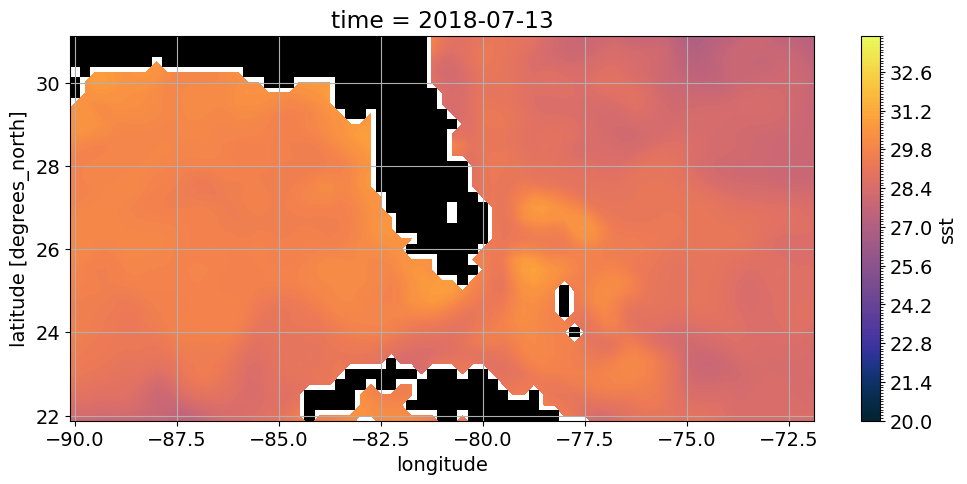

In [151]:
fig = plt.figure(figsize=(12, 5))

contour_surf(sst_resampled, fig, 193)

In [152]:
sst = Movie(sst_resampled, contour_surf, input_check=False)

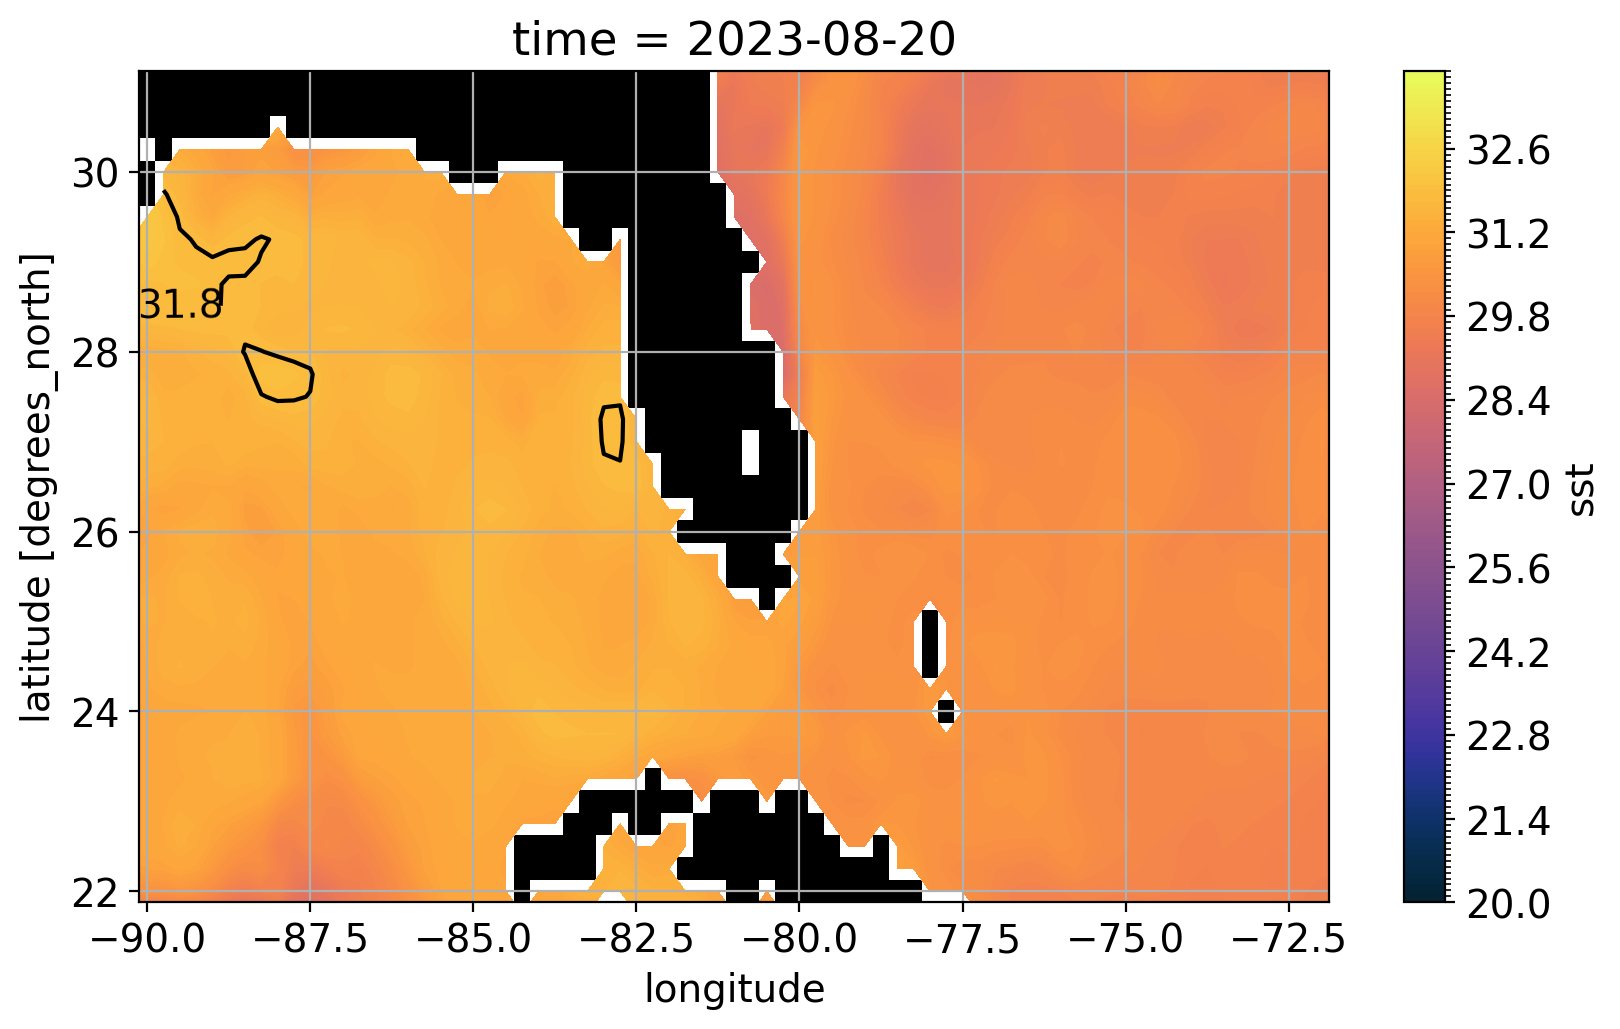

In [153]:
sst.preview(-40)

In [154]:
#save sst movie
sst.save('sst-31_8-contour.mp4', progress=True, overwrite_existing=True)

  0%|          | 0/2097 [00:00<?, ?it/s]

Movie created at sst-31_8-contour.mp4
